# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [5]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [7]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [8]:
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
    
print('Data has been read correctly!')

Data has been read correctly!


## EDA

Let's check the number of movies and reviews over years.

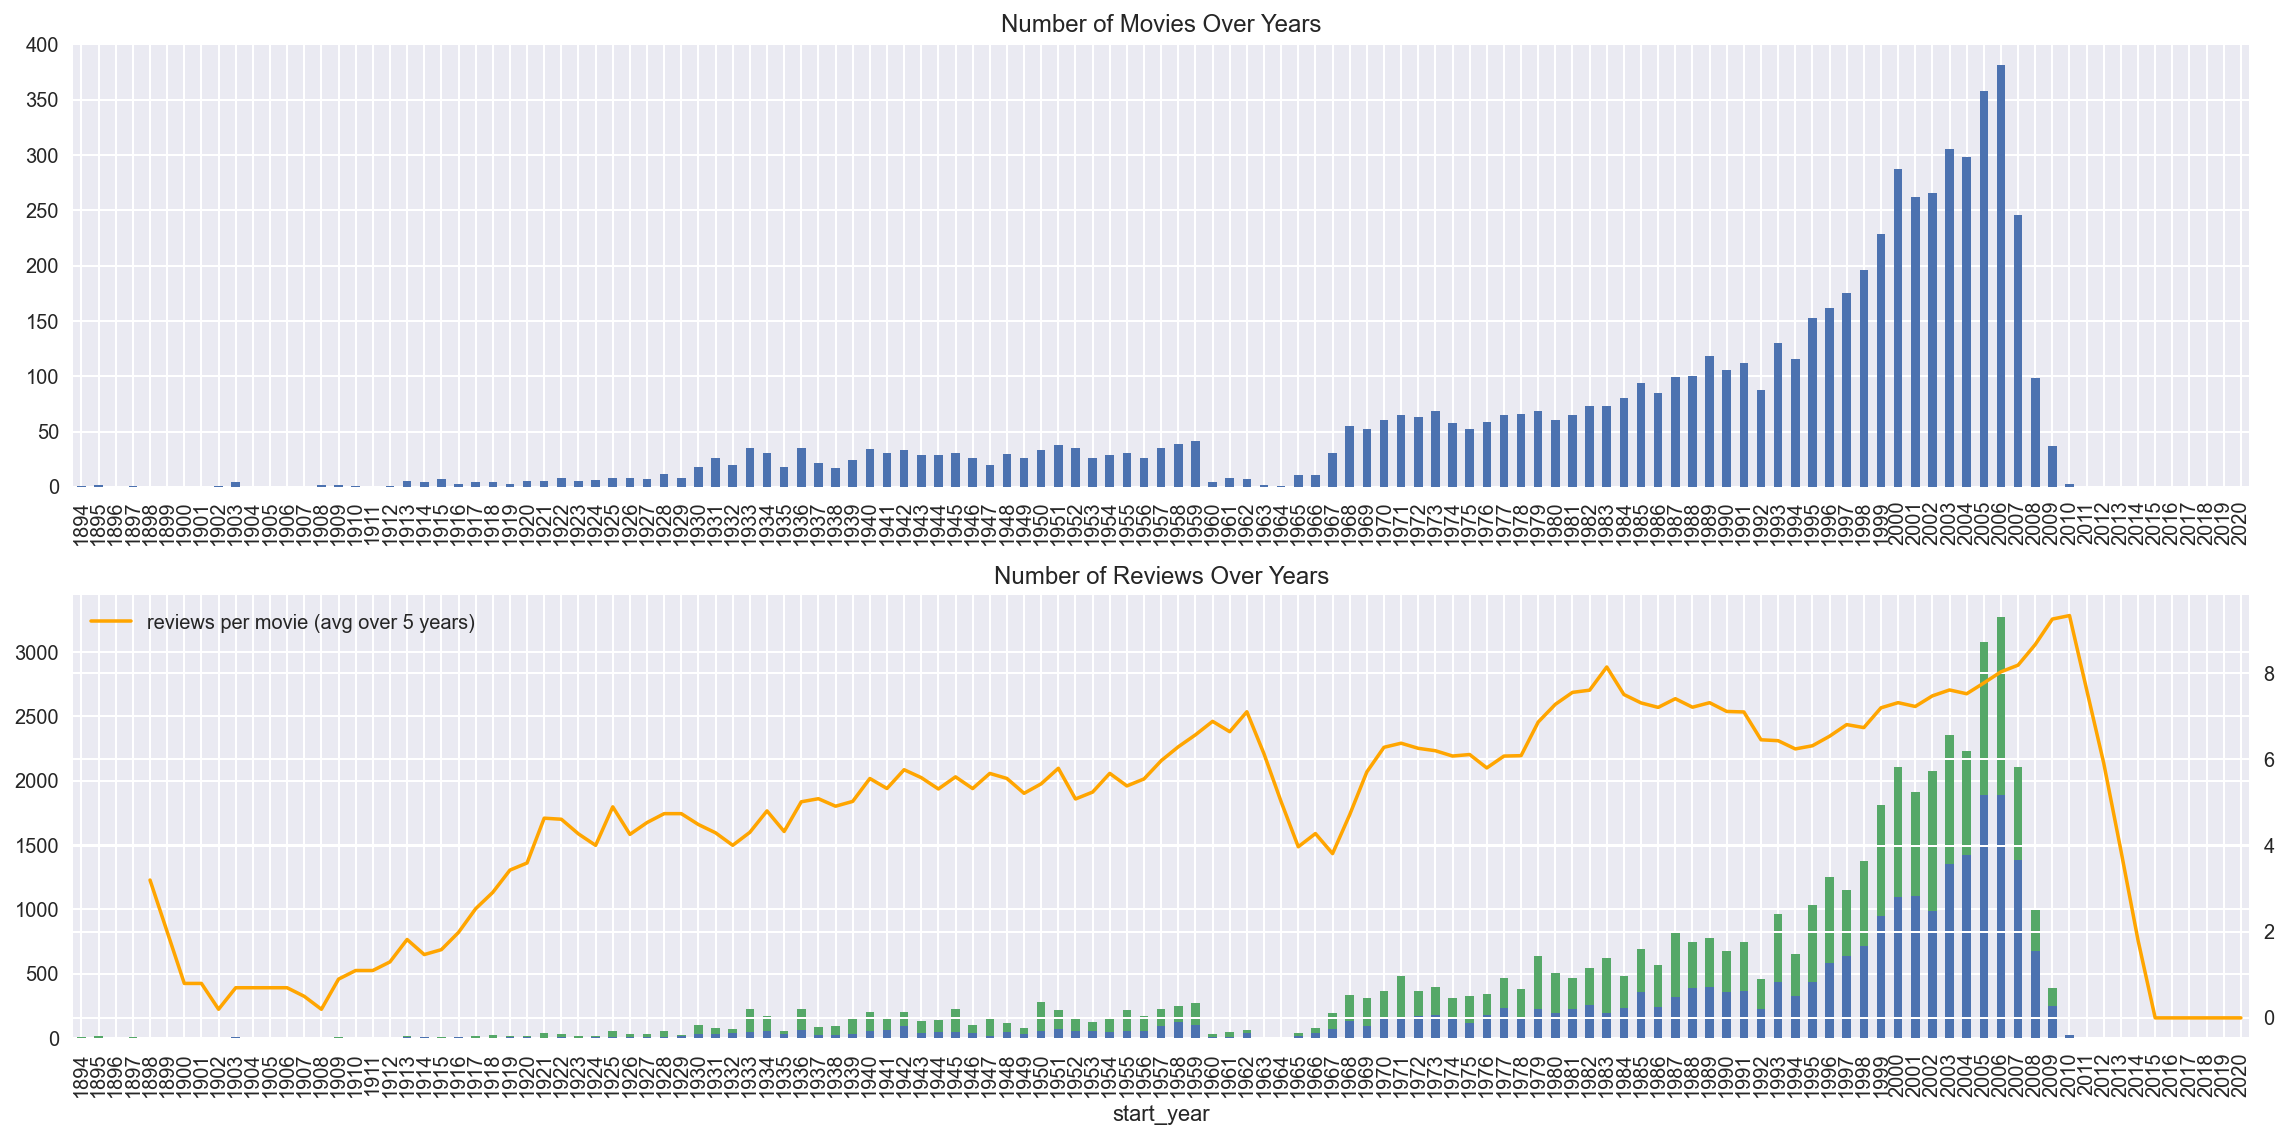

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Up until 1930 only number of individual films were reviewed each year. After that until 1959 only a few dozen were movie reviewed per year. Then until 1967 there was a decline in the yearly amount reviewed movies and later a growing amount every year that came to a peak of almost 400 reviews in 2006 and later a decline.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

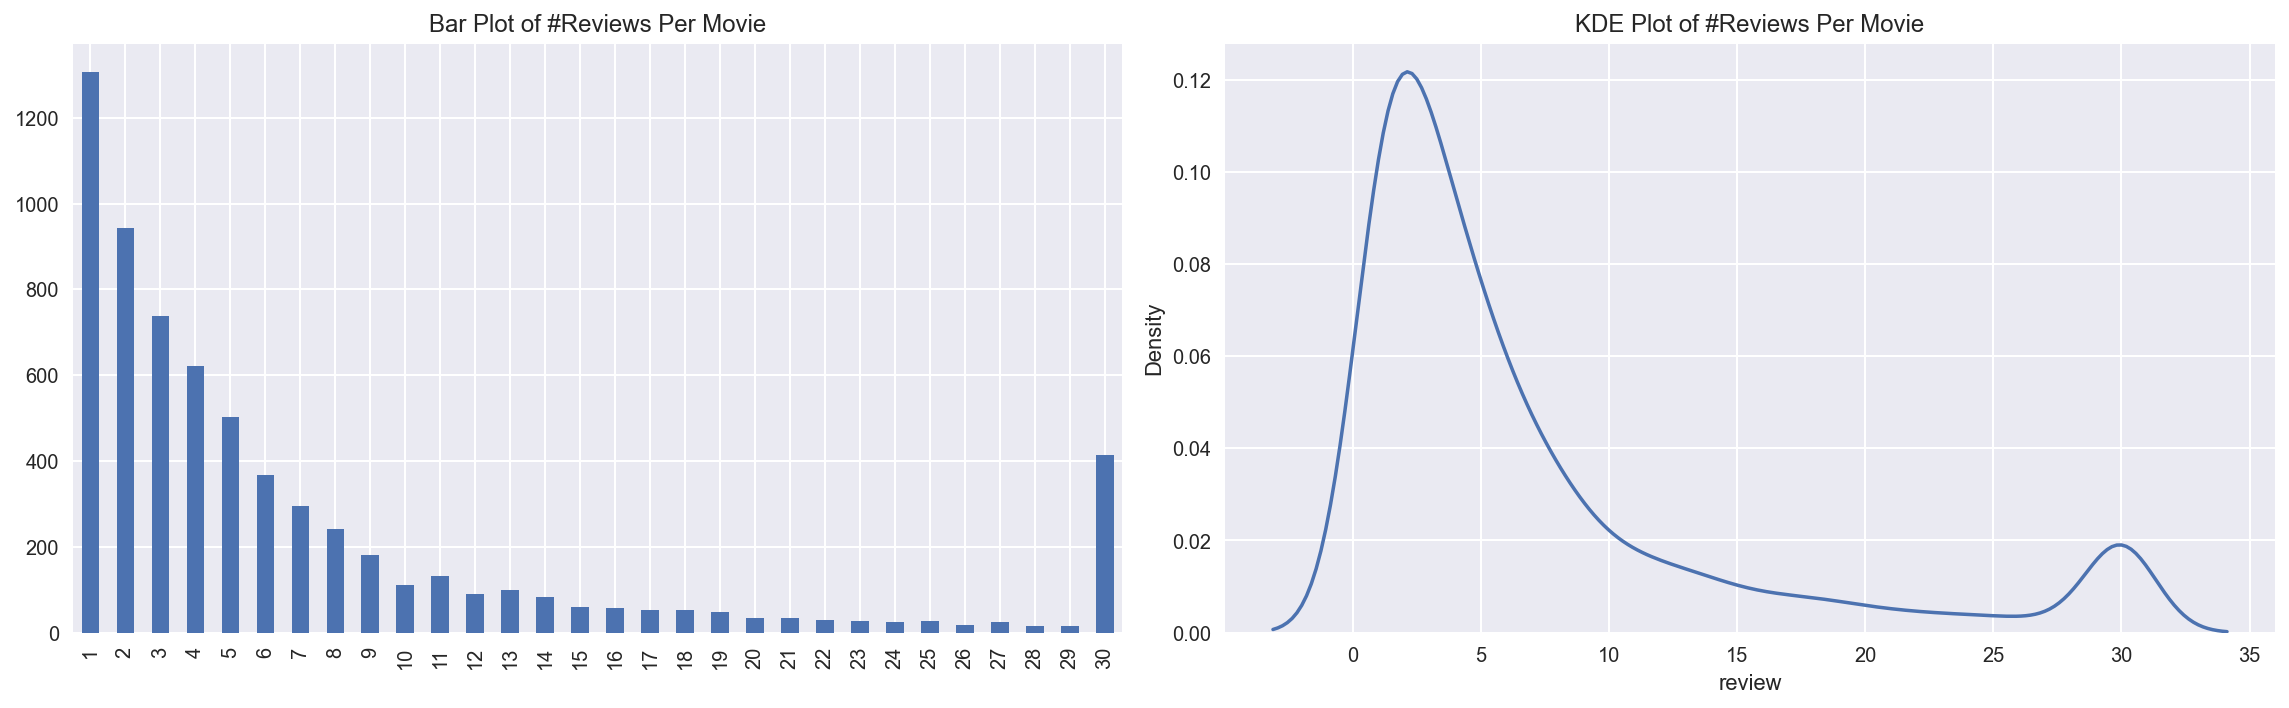

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

We can see that the most common amount of reviews per movie is 1 and there is an interesting peak in 30 reviews also. 

0    23715
1    23616
Name: pos, dtype: int64


<AxesSubplot:ylabel='pos'>

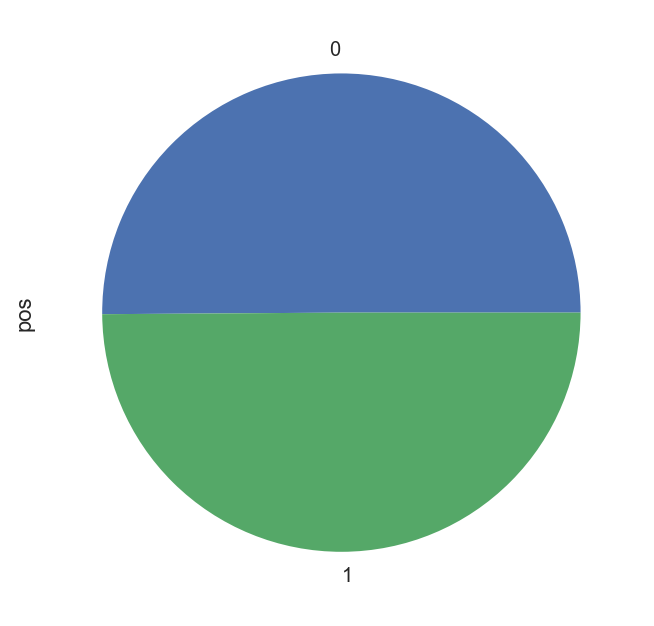

In [11]:
print(df_reviews['pos'].value_counts())
df_reviews['pos'].value_counts().plot.pie()

The reviews are balanced between positive and negative. 

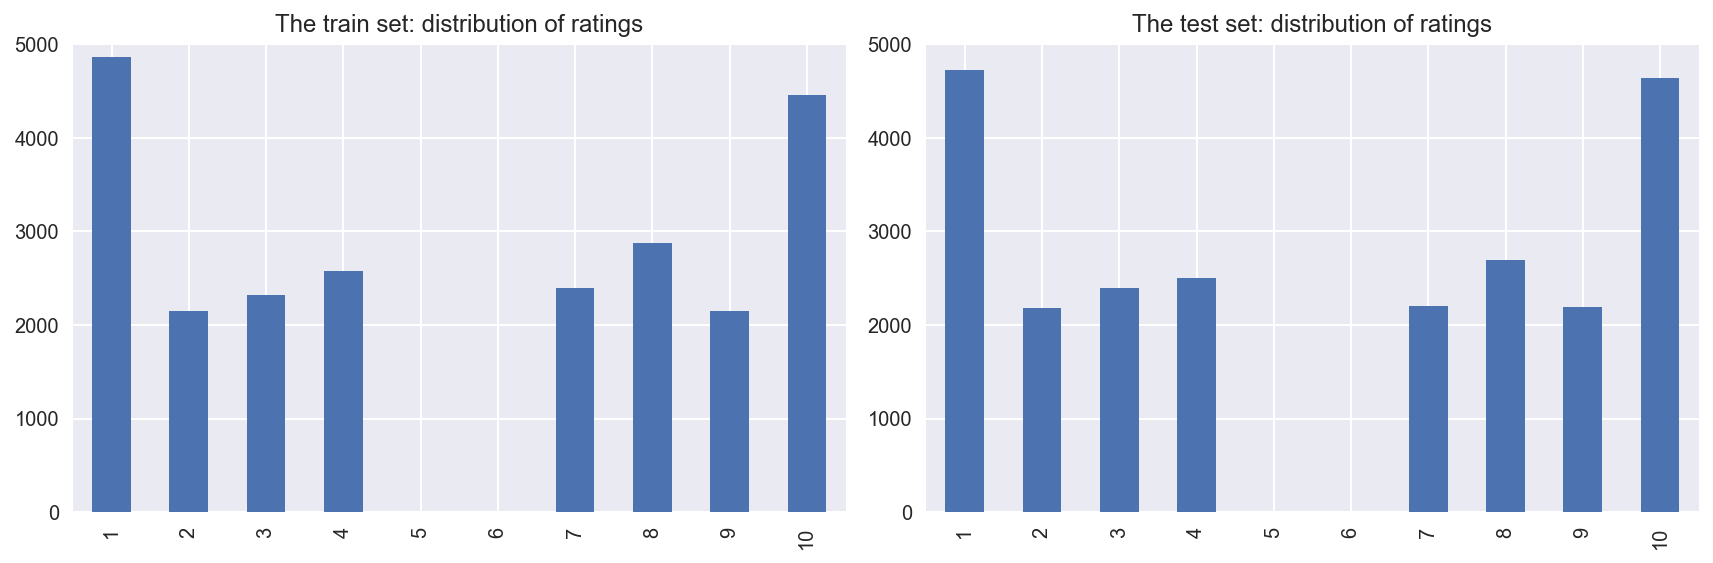

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Rating distribution looks balanced between the train and the test.

Distribution of negative and positive reviews over the years for two parts of the dataset

C:\Users\nirga\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\nirga\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\nirga\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\nirga\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


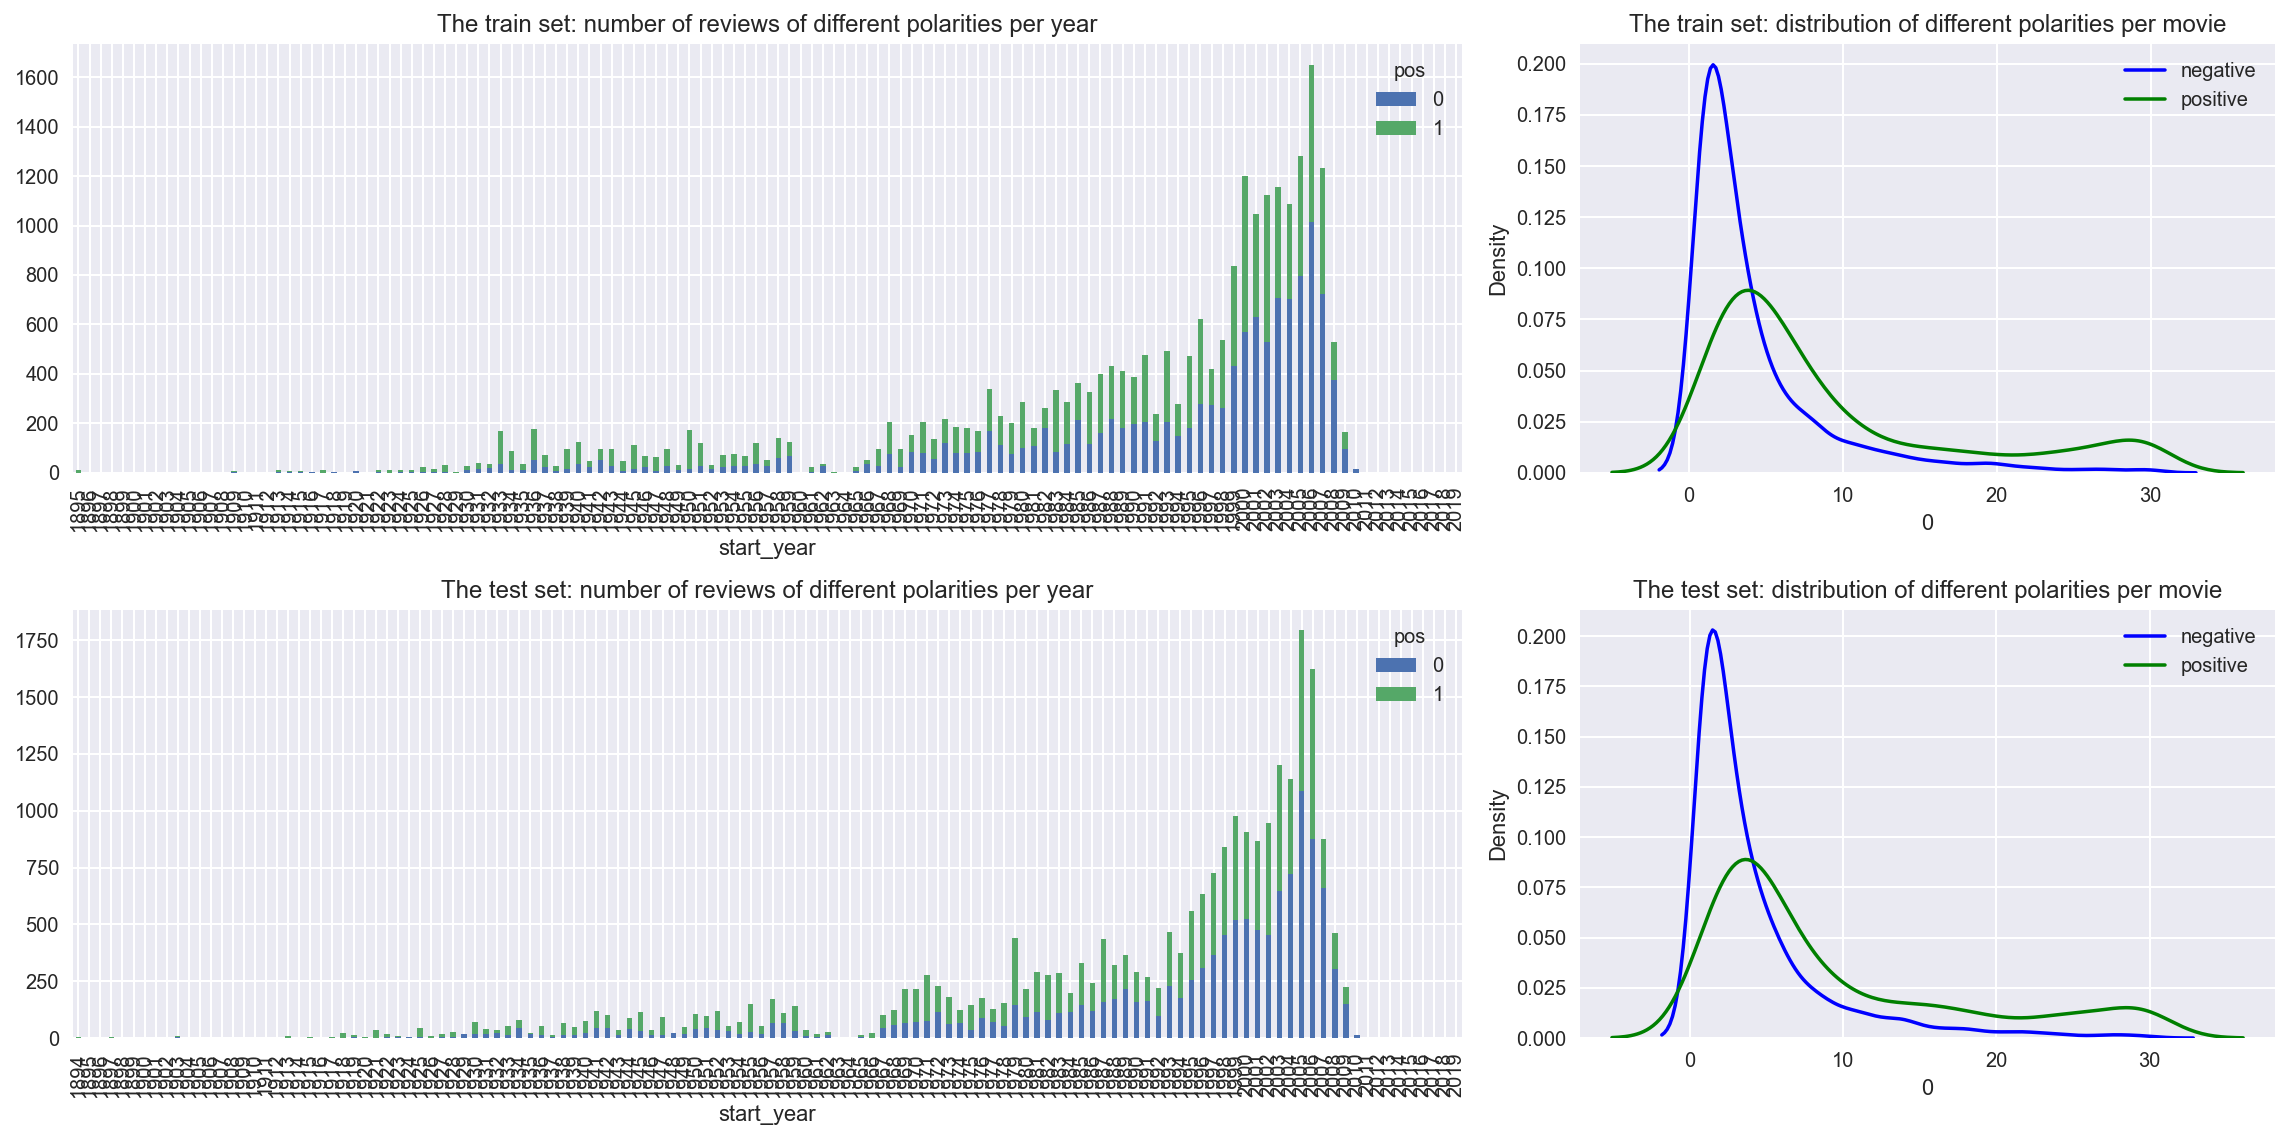

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The polarity of positive and negative reviews between the train and the test looks balanced.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
import time

In [16]:
import re
!pip install -U spacy
import spacy

In [17]:
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # https://spacy.io/usage/processing-pipelines

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-08-24 17:14:45.710630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-08-24 17:14:45.710678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-24 17:14:51.085326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-08-24 17:14:51.085358: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-24 17:14:51.089432: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-SKRCPOF
2022-08-24 17:14:51.089522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-SKRCPOF


In [18]:
def clear_text(text):
    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = " ".join(clean_text.split())
    return clean_text

In [19]:
def lemmatize(text):
    doc = nlp(text.lower())
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

In [20]:
def lemm_clear(row):
    row_text = row['review']
    return lemmatize(clear_text(row_text))

In [21]:
small_df = df_reviews.sample(500)

In [22]:
t = time.time()
small_df['review_norm'] = small_df.apply(lemm_clear, axis=1)
elapsed = time.time() - t
print(f'The time for 500 samples is {round(elapsed,1)} seconds')

The time for 500 samples is 11.8 seconds


In [23]:
minutes = round(df_reviews.shape[0]*elapsed/60/500, 1)
print(f'The total time to run the lemm_clear func on all df will be {minutes} minutes')

The total time to run the lemm_clear func on all df will be 18.7 minutes


In [24]:
%%time

df_reviews['review_norm'] = df_reviews.apply(lemm_clear, axis=1)

Wall time: 13min 18s


#### remove markdown if want to save the normalize version

# save normalize version
df_reviews.to_csv('imdb_reviews_normalize.tsv', sep="\t")

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

## Load the normalize data

#### remove markdown if want to load the normalize version

try:
    df_reviews = pd.read_csv('imdb_reviews_normalize.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews_normalize.tsv', sep='\t', dtype={'votes': 'Int64'})
    
print('Data has been read correctly!')

In [26]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [36]:
from sklearn.dummy import DummyClassifier

In [37]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(df_reviews_train, train_target)

DummyClassifier(strategy='most_frequent')

In [38]:
dummy_clf.predict(df_reviews_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


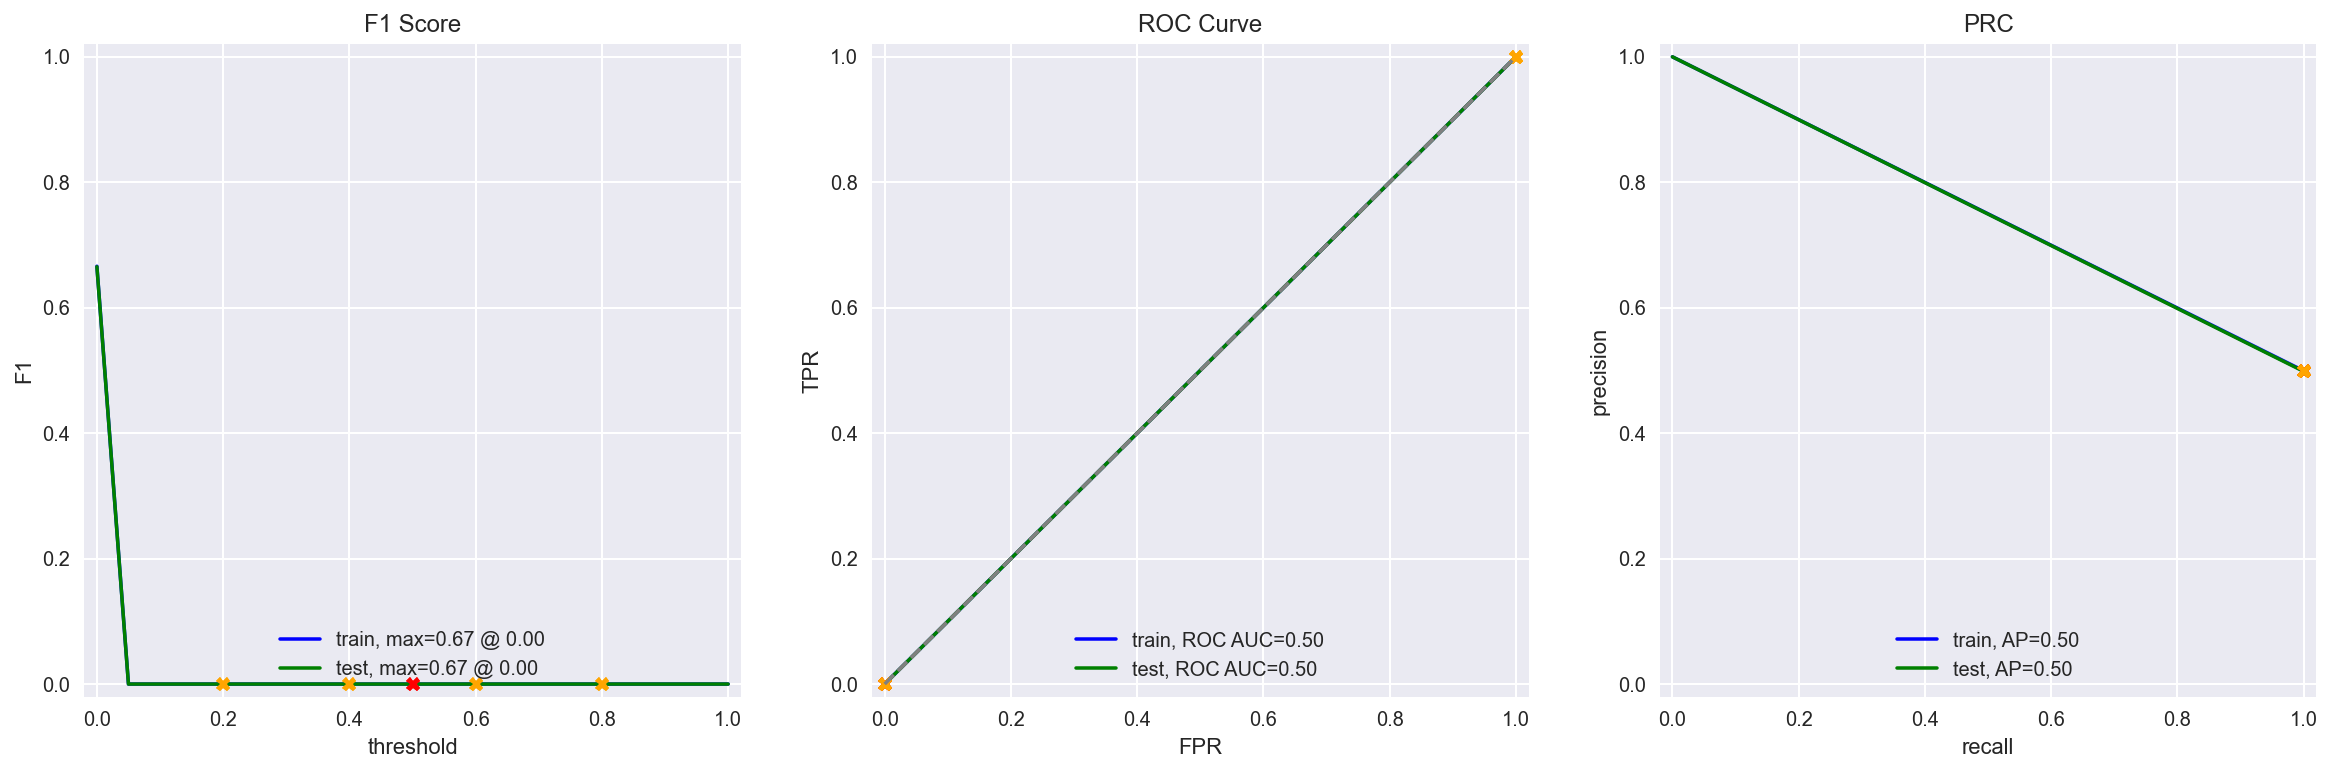

In [39]:
evaluate_model(model=dummy_clf,
               train_features=df_reviews_train,
               train_target=train_target,
               test_features=df_reviews_test,
               test_target=test_target)

In the other models we must get results better then the dummy model

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [44]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords

#### fit model

In [112]:
corpus_train = df_reviews_train['review']

stop_words = set(nltk_stopwords.words('english'))

count_tf_idf_1 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf_1.fit_transform(corpus_train)
tf_idf_train.shape

(23796, 73081)

In [113]:
tf_idf_train_target = df_reviews_train['pos']

In [114]:
model_1 = LogisticRegression(random_state=12345, solver='liblinear')
model_1.fit(tf_idf_train, tf_idf_target)

LogisticRegression(random_state=12345, solver='liblinear')

#### predict

In [115]:
corpus_test = df_reviews_test['review']

In [116]:
tf_idf_test = count_tf_idf_1.transform(corpus_test)

In [117]:
tf_idf_test_target = df_reviews_test['pos']

#### evaluate

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


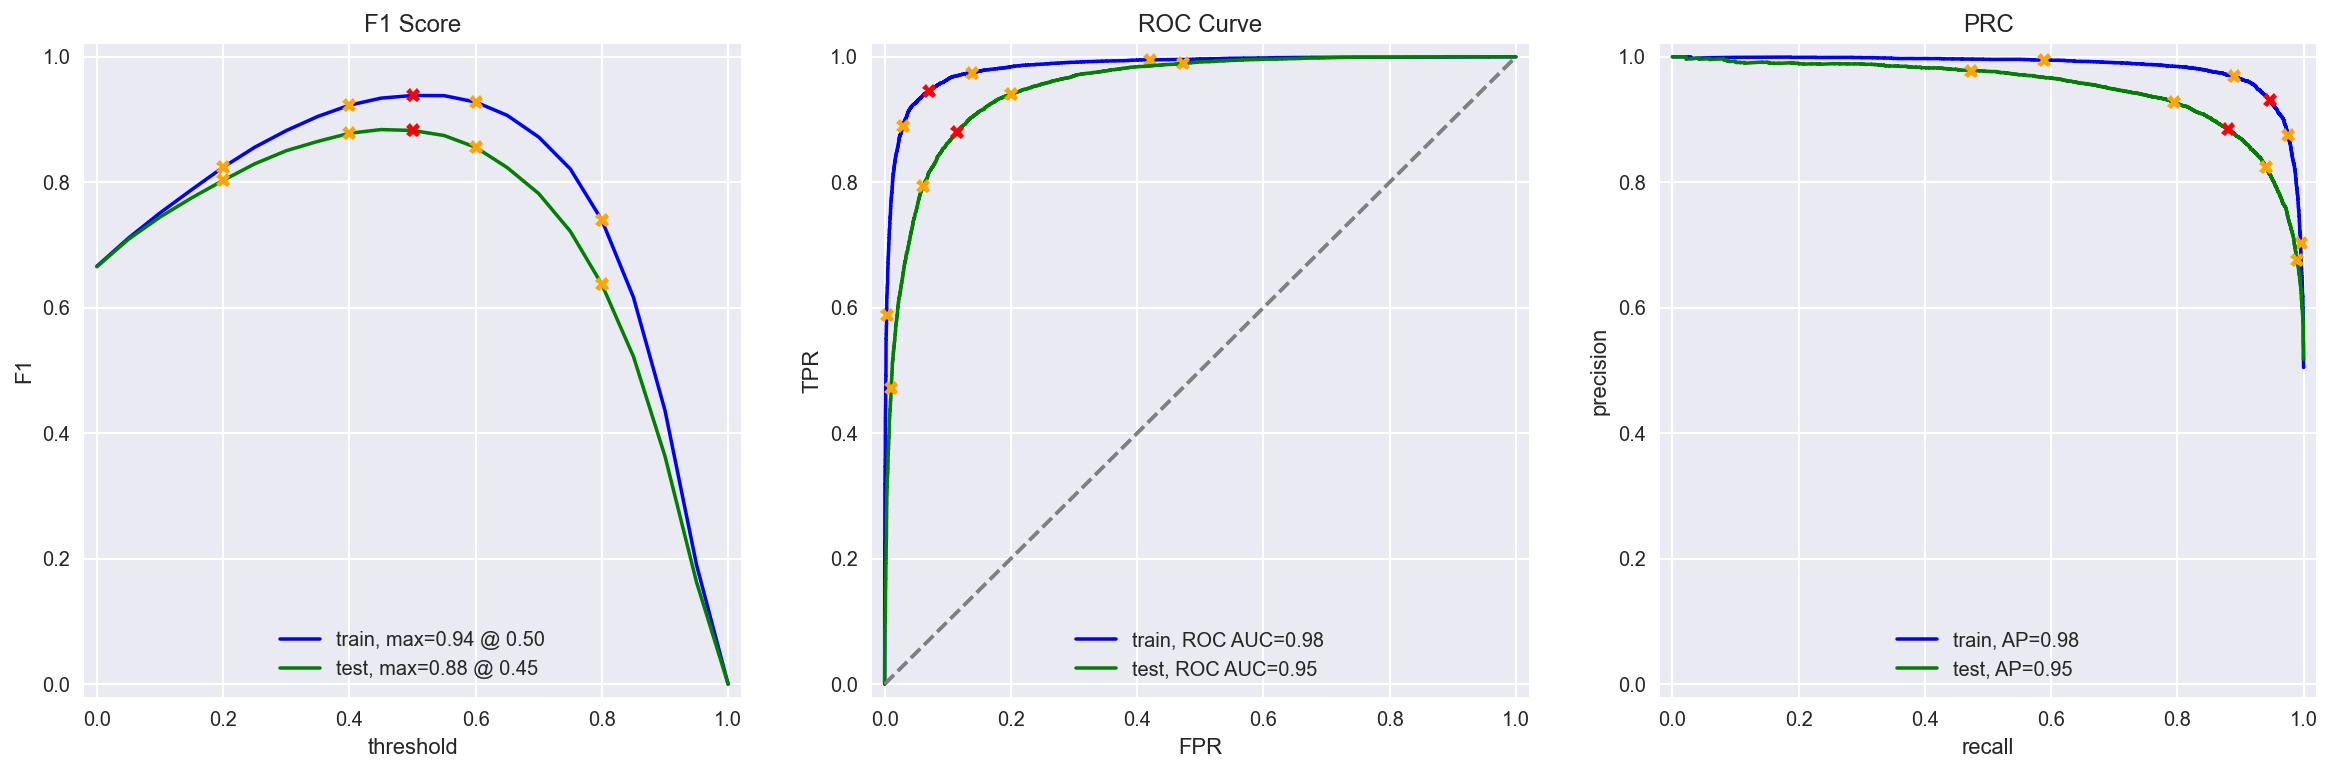

In [118]:
evaluate_model(
    model=model_1,
    train_features=tf_idf_train,
    train_target=tf_idf_train_target,
    test_features=tf_idf_test,
    test_target=tf_idf_test_target,
)

### Model 3 - spaCy, TF-IDF and LR

Same as before only now use the normalized review instead of the original review

I already did preprocessing for the text in the Normalization section so I markdown the pre code 

import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    
    return ' '.join(tokens)

In [124]:
corpus_train = df_reviews_train['review_norm']

stop_words = set(nltk_stopwords.words('english'))

count_tf_idf_3 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf_3.fit_transform(corpus_train)
tf_idf_train.shape

(23796, 59241)

In [125]:
tf_idf_train_target = df_reviews_train['pos']

#### fit model

In [126]:
model_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_3.fit(tf_idf_train, tf_idf_target)

LogisticRegression(random_state=12345, solver='liblinear')

#### predict

In [127]:
corpus_test = df_reviews_test['review_norm']

In [128]:
tf_idf_test = count_tf_idf_3.transform(corpus_test)

In [129]:
tf_idf_test_target = df_reviews_test['pos']

#### evaluate

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


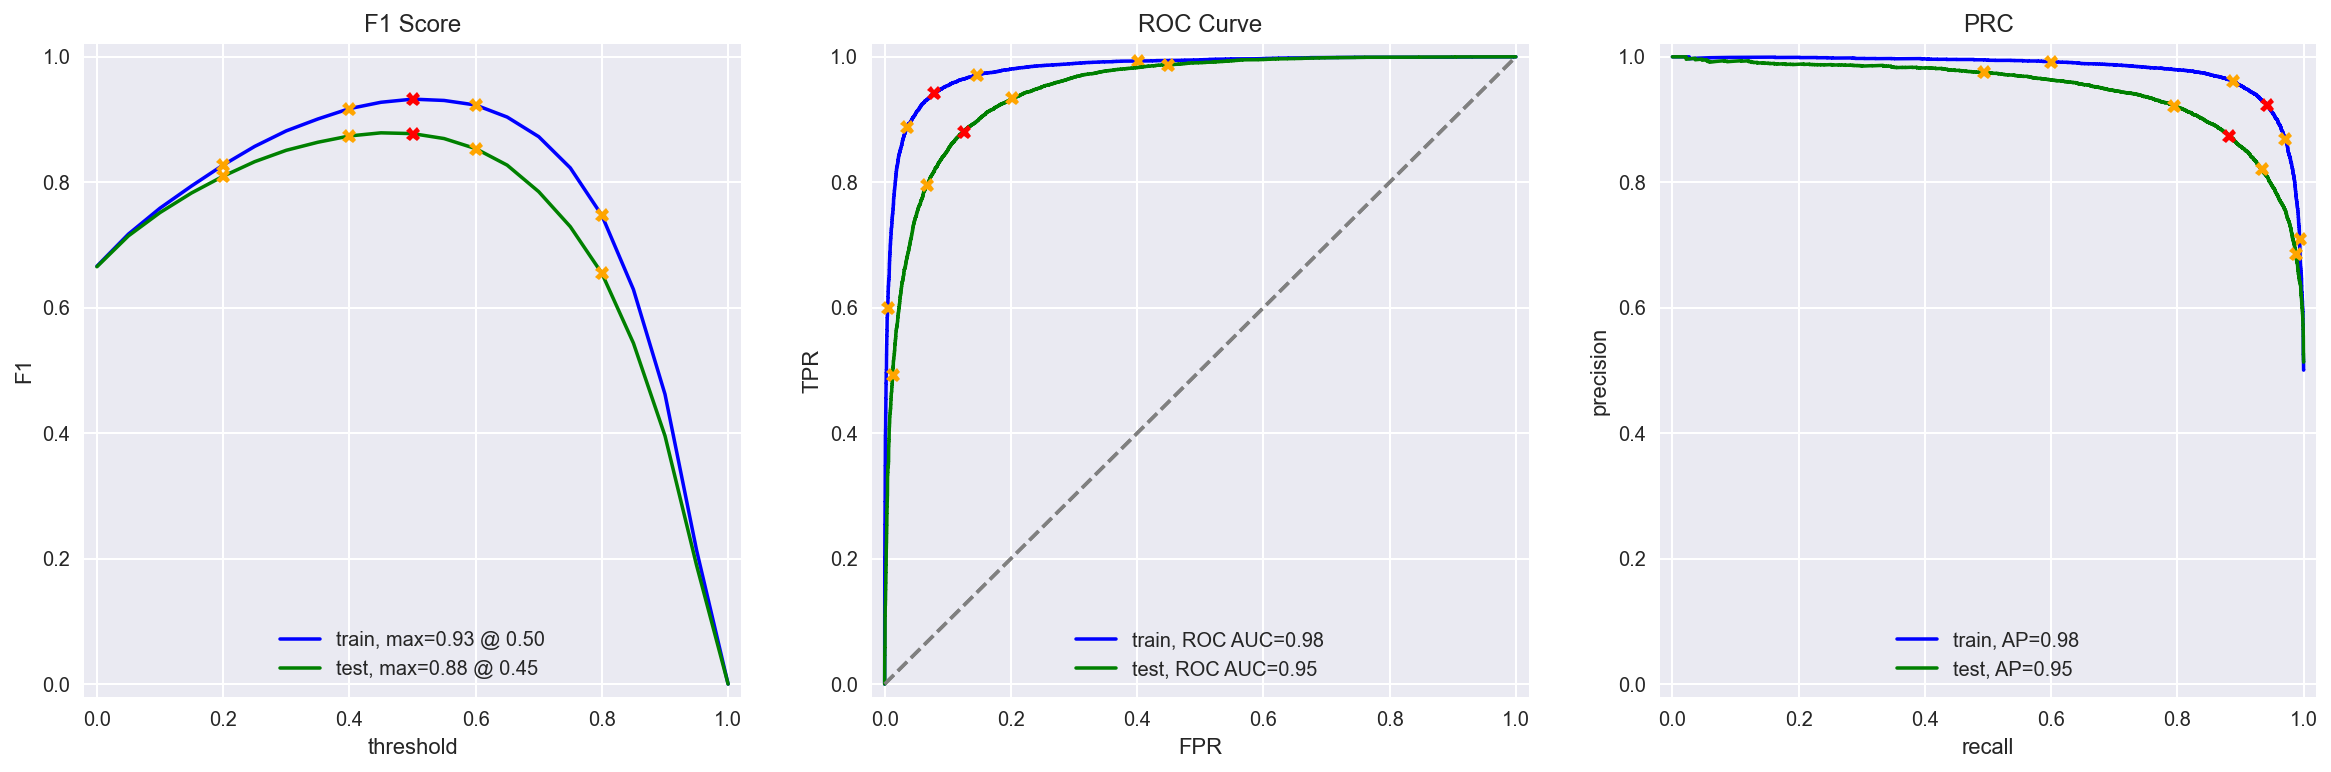

In [130]:
evaluate_model(
    model=model_3,
    train_features=tf_idf_train,
    train_target=tf_idf_train_target,
    test_features=tf_idf_test,
    test_target=tf_idf_test_target,
)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

Now use LGBMClassifier on the normalized review

In [83]:
from lightgbm import LGBMClassifier

#### fit model

In [86]:
model_4 = LGBMClassifier(random_state=12345)
model_4.fit(tf_idf_train, tf_idf_target)

LGBMClassifier(random_state=12345)

#### evaluate

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


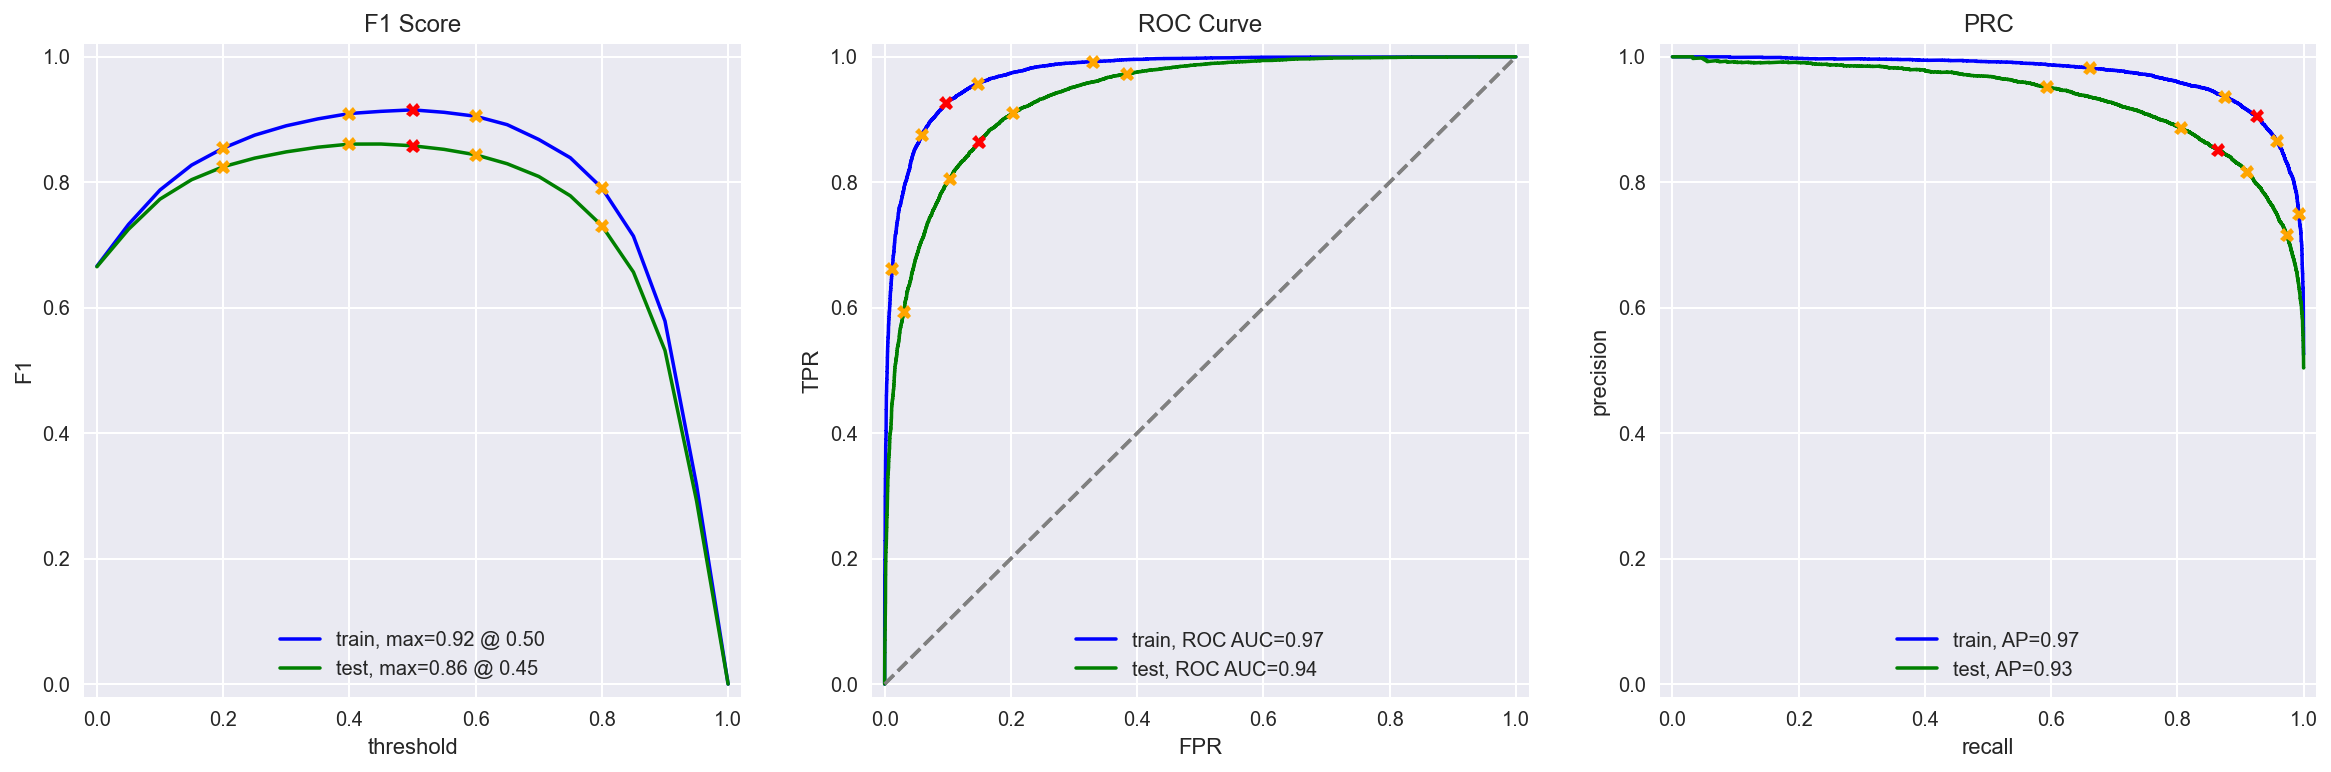

In [87]:
evaluate_model(
    model=model_4,
    train_features=tf_idf_train,
    train_target=tf_idf_train_target,
    test_features=tf_idf_test,
    test_target=tf_idf_test_target,
)

###  Model 9 - BERT

In [90]:
!pip install torch
!pip install transformers
import torch
import transformers

In [91]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [102]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    max_length = 512

    for input_text in df_reviews.iloc[:batch_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [103]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

# I will do with cpu
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'])

Using the cpu device.


  0%|          | 0/1 [00:00<?, ?it/s]

In [142]:
max_sample_size = 100

In [143]:
train_target_9 = df_reviews_train.iloc[:max_sample_size]['pos']

In [144]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target_9.shape)
print(train_target.shape)

(23796,)
(100, 768)
(100,)
(23796,)


In [105]:
# I will do with cpu - now for test
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'])

Using the cpu device.


  0%|          | 0/1 [00:00<?, ?it/s]

In [145]:
test_target_9 = df_reviews_test.iloc[:max_sample_size]['pos']

In [146]:
print(df_reviews_test['review_norm'].shape)
print(test_features_9.shape)
print(test_target_9.shape)
print(test_target.shape)

(23535,)
(100, 768)
(100,)
(23535,)


In [107]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)



In [108]:
# and load...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

#### fit model

In [151]:
model_9 = LogisticRegression(random_state=12345, solver='liblinear')
model_9.fit(train_features_9, train_target_9)

LogisticRegression(random_state=12345, solver='liblinear')

#### predict

corpus_test = df_reviews_test['review_norm']

tf_idf_test = count_tf_idf_3.transform(corpus_test)

tf_idf_test_target = df_reviews_test['pos']

#### evaluate

          train  test
Accuracy    1.0  0.73
F1          1.0  0.77
APS         1.0  0.65
ROC AUC     1.0  0.74


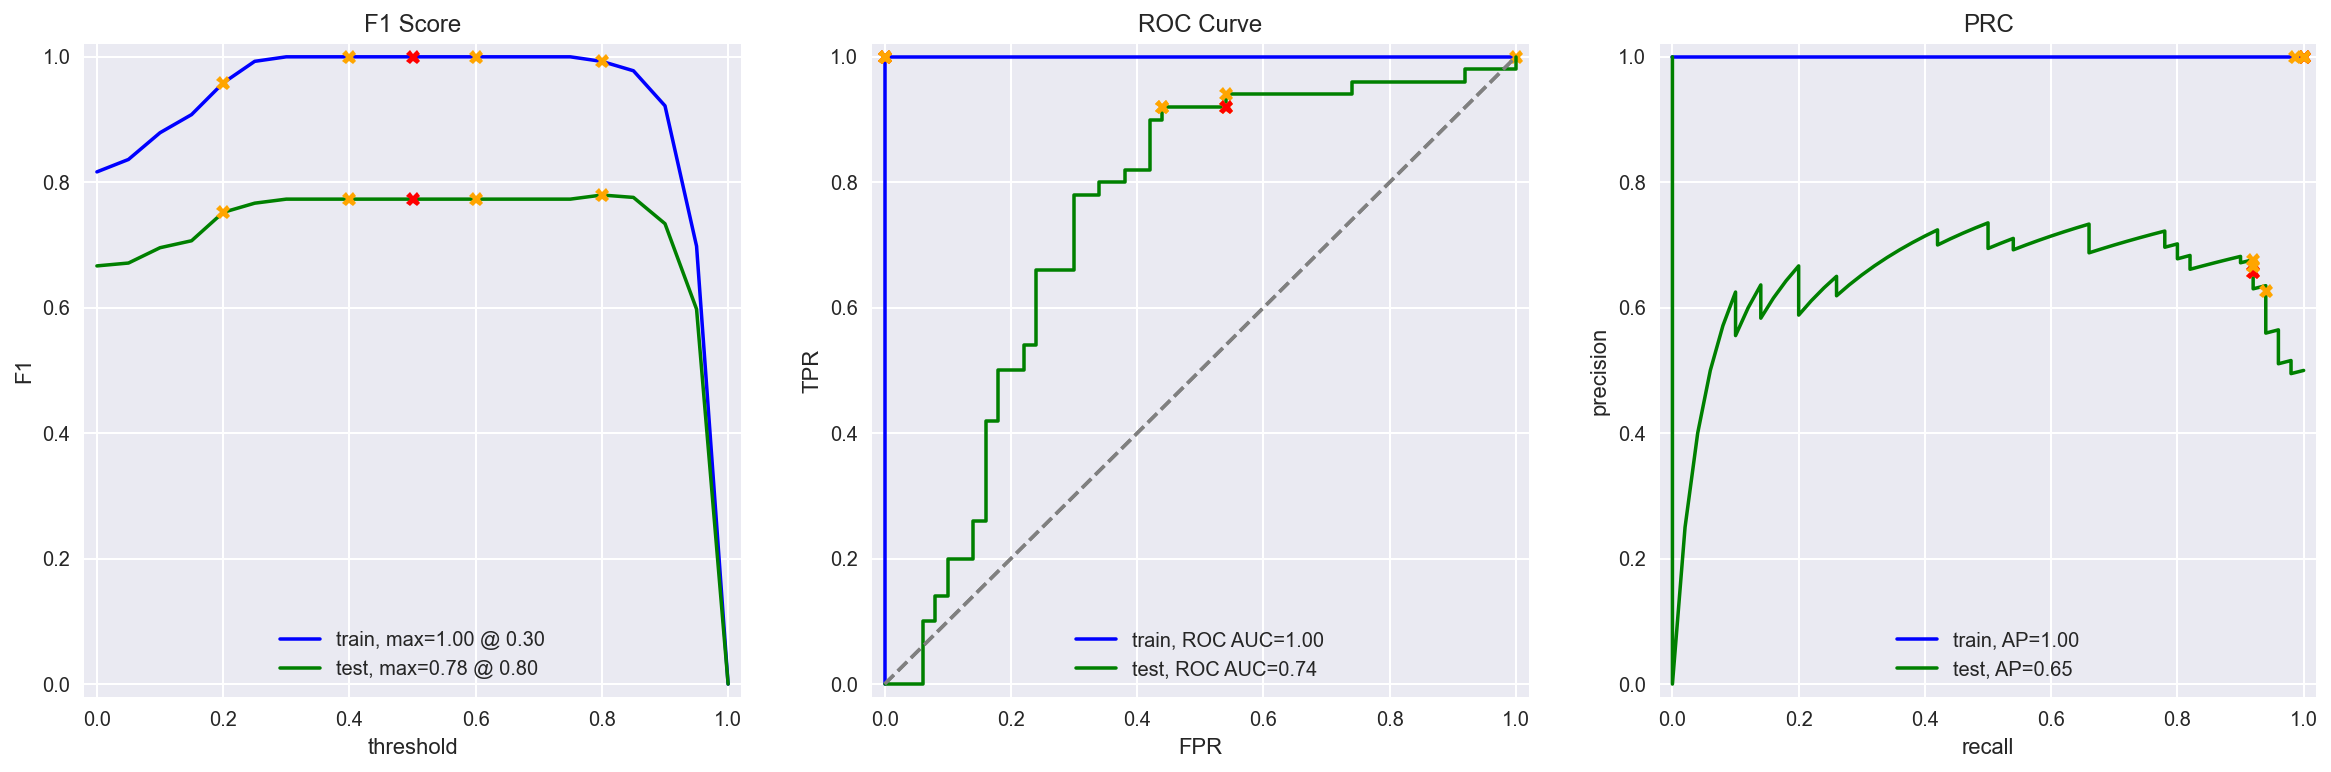

In [152]:
evaluate_model(
    model=model_9,
    train_features=train_features_9,
    train_target=train_target_9,
    test_features=test_features_9,
    test_target=test_target_9,
)

## My Reviews

In [158]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, \
not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, \
and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really \
cared about the source material',
    'The movie had its upsides and downsides, but I feel like \
overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, \
everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being \
able to binge on episode after episode, of this exciting intelligent new drama.',
    'This is a bed movie',
    'This is an amzing movie'
], columns=['review'])

my_reviews['review_norm'] = my_reviews.apply(lemm_clear, axis=1)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I do not expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launch on netflix be a brave move I really app...
8,This is a bed movie,this be a bed movie
9,This is an amzing movie,this be an amzing movie


### Model 1

In [159]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.13:  I do not simply like it not my kind of movie
0.26:  well I be bored and feel asleep in the middle of the movie
0.53:  I be really fascinated with the movie
0.16:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.28:  I do not expect the reboot to be so good writer really care about the source material
0.55:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.82:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t
0.40:  this be a bed movie
0.35:  this be an amzing movie


### Model 3

In [160]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  I do not simply like it not my kind of movie
0.10:  well I be bored and feel asleep in the middle of the movie
0.48:  I be really fascinated with the movie
0.13:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.26:  I do not expect the reboot to be so good writer really care about the source material
0.50:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.92:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t
0.41:  this be a bed movie
0.39:  this be an amzing movie


### Model 4

In [161]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = count_tf_idf_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  I do not simply like it not my kind of movie
0.35:  well I be bored and feel asleep in the middle of the movie
0.59:  I be really fascinated with the movie
0.41:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.70:  I do not expect the reboot to be so good writer really care about the source material
0.63:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.25:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.81:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t
0.59:  this be a bed movie
0.59:  this be an amzing movie


### Model 9

In [162]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  I do not simply like it not my kind of movie
0.20:  well I be bored and feel asleep in the middle of the movie
0.14:  I be really fascinated with the movie
0.06:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.01:  I do not expect the reboot to be so good writer really care about the source material
0.20:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.26:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t
0.15:  this be a bed movie
0.07:  this be an amzing movie


## Conclusions

From the models the one that tend to determine the reviews are positive is model_4 (lgbm) and the most pasimistic one is model_9 (BERT). 

The strange thing is that the two lines of review I added "This is a bed movie" and "This is an amzing movie" didn't work as I expected. In model 4 they both got the same probability for positive review and in model_9 which I assume will work the best I got better probability for the bed review

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions